In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

import os
# which folder
# find the next available folder
def get_latest_folder(base_name):
    index = 1
    while True:
        folder = f"{base_name}_{index}"
        if not os.path.exists(folder):
            folder = f"{base_name}_{index-1}"
            return folder
        index += 1
folder = get_latest_folder("world")
# Function to get the next available filename
def get_latest_filename(base_name, extension):
    index = 1
    while True:
        filename = f"{base_name}_{index}.{extension}"
        if not os.path.exists(filename):
            filename = f"{base_name}_{index-1}.{extension}"
            return filename
        index += 1
def get_next_filename(base_name, extension):
    index = 1
    while True:
        filename = f"{base_name}_{index}.{extension}"
        if not os.path.exists(filename):
            return filename
        index += 1

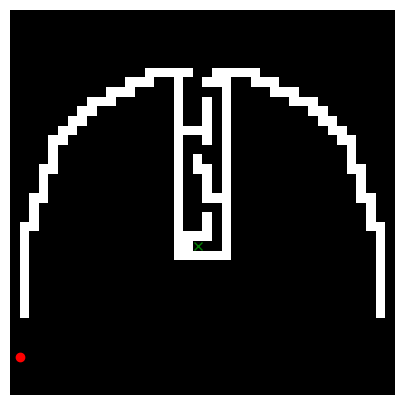

In [2]:
from maze_PTR_model import MazePTRModel
model = MazePTRModel()
checkpoint = torch.load(f"{folder}/models/last_model.pt")
model.load_state_dict(checkpoint)
model.eval()

from maze_env import Maze
env = Maze(sparse=False, model=model)
env.plot()

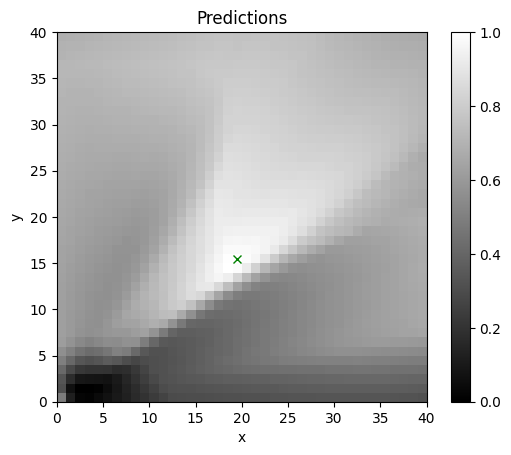

In [3]:
# plot the predictions over a 2D grid 
def plot_predictions(model, env):
    # create a 2D grid
    x = np.linspace(0, env.Nx-1, env.Nx)
    y = np.linspace(0, env.Ny-1, env.Ny)
    Y, X = np.meshgrid(x, y)
    
    # create a tensor of the grid
    grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float)
    # get the predictions
    time_proximity_to_goal = model.predict_time_to_goal(grid).detach().numpy()
    # reshape the predictions
    time_proximity_to_goal = time_proximity_to_goal.reshape(env.Nx, env.Ny)
    #rewards = np.exp(-1*time_proximity_to_goal)
    time_proximity_to_goal = (time_proximity_to_goal - np.min(time_proximity_to_goal))/(np.max(time_proximity_to_goal) - np.min(time_proximity_to_goal))
    rewards = 1 - time_proximity_to_goal
    # plot the predictions
    plt.imshow(rewards.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    plt.colorbar()
    plt.plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predictions')
    plt.show()
model.eval()
plot_predictions(model, env)

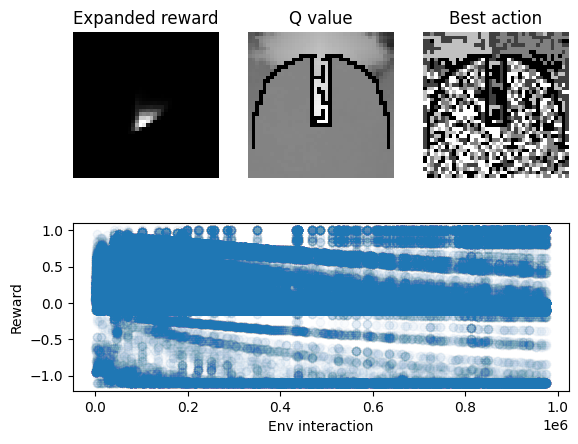

In [4]:
# clear the gifs folder content
import glob
#for f in glob.glob(f"gifs/*"):
#    os.remove(f)

# test value iteration on the grid
#Create new env with estimated reward and train agent
new_env = Maze(sparse=False, model=model, move_penalty=0.1, collision_penalty=1.0)
newQ = new_env.train_Q_1_epoch(episodes=2000, episode_length=500,alpha=0.5,gamma=0.99,final_greediness=0.5,eps_anneal=True,disp=True,
                               plot_freq=50, reward_shrink=10, shrink_freq=50, save_folder="gif_image_buffer")

In [5]:
image_files = []
# append filenames continually until we have all of them
index = 0
while True:
    filename = f"gif_image_buffer/img_{index}.png"
    if not os.path.exists(filename):
        break
    image_files.append(filename)
    index += 1

import imageio
images = []
# the first image is corrupt
for i in range(1, len(image_files)):
    filename = image_files[i]
    images.append(imageio.imread(filename))
# get next output file name
output_file = get_next_filename(f"{folder}/output", "gif")
imageio.mimsave(output_file, images)

# clear the gifs folder
for filename in image_files:
    os.remove(filename)

/tmp/ipykernel_10857/444874203.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


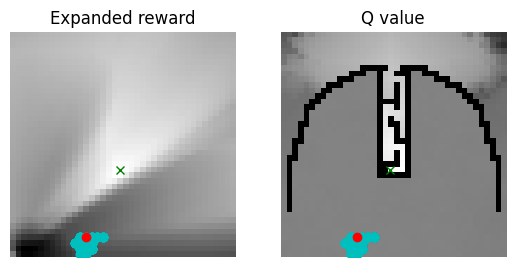

In [6]:
# Test agent on original world
test_env = Maze(sparse=False, model=model, move_penalty=0.0, collision_penalty=1.0)
traj, success = test_env.test_Q_once(newQ,episode_length=300,disp=True, final_greediness=0.8, eps_anneal=False)